In [210]:
!pip install nltk
!pip install Sastrawi
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

import nltk
nltk.download('punkt')
import Sastrawi
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer

# Modeling Utilities
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For resampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN, ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN

# Ensemble Classifiers
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [211]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
# Membaca data
path = "/content/drive/Shared drives/MLL + NLP/Text Classification NLP/dataset/"
train = pd.read_csv(path+"train.csv",encoding="Latin-1")
test = pd.read_csv(path+"test.csv",encoding="Latin-1")
dev = pd.read_csv(path+"dev.csv",encoding="Latin-1")

Overview data

In [214]:
train.head()

,Unnamed: 0,text_a,label
0,0,betewe buka twitter cuman ngetweet liat home b...,no
1,1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,2,e100ss gini buka informasi sejelas nya identit...,yes
3,3,neng solo wes ono terduga corona cobo neng ati...,no
4,4,midiahn nii akun gak takut takut nya isu coron...,no


In [215]:
train = train.drop(columns=['Unnamed: 0'])
train.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


In [216]:
print("Train shape\t:",train.shape)
print("Test shape\t:",test.shape)
print("Dev shape\t:",dev.shape)

Train shape	: (21601, 2)
Test shape	: (2800, 2)
Dev shape	: (2800, 2)


In [217]:
# Jumlah data berlabel positif dan negatif pada data training
count_yes = train[train['label']=='yes'].shape[0]
count_no = train[train['label']=='no'].shape[0]
percentage_yes = count_yes / (count_yes + count_no)
percentage_no = count_no / (count_yes + count_no)
print("Yes:",count_yes,"\t",percentage_yes)
print("No:",count_no,"\t",percentage_no)

Yes: 6089 	 0.2818850979121337
No: 15512 	 0.7181149020878663


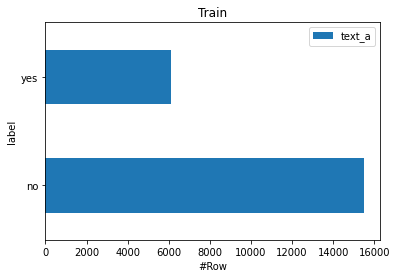

In [218]:
train.groupby(['label']).count().plot(kind='barh')
plt.title('Train')
plt.xlabel('#Row')
plt.show()

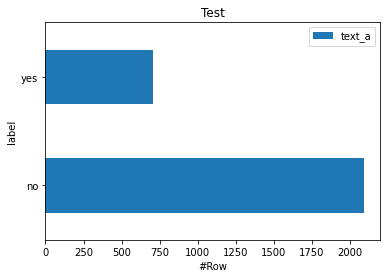

In [219]:
test.groupby(['label']).count().plot(kind='barh')
plt.title('Test')
plt.xlabel('#Row')
plt.show()

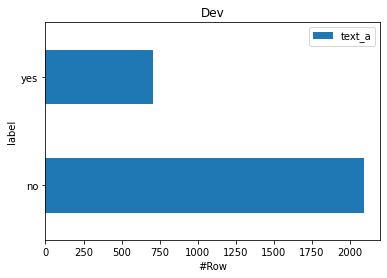

In [220]:
dev.groupby(['label']).count().plot(kind='barh')
plt.title('Dev')
plt.xlabel('#Row')
plt.show()

In [221]:
def evaluation(y_test, y_pred):
  # Model Accuracy
  print("Accuracy\t:",accuracy_score(y_test, y_pred))
  # # Model Precision
  # print("Precision\t:",precision_score(y_test, y_pred,average="binary", pos_label="yes"))
  # # Model Recall
  # print("Recall\t\t:",recall_score(y_test, y_pred,average="binary", pos_label="yes"))
  # Model F1
  print("F1\t\t:", f1_score(y_test, y_pred,average="binary", pos_label="yes"))

  # Confusion Matrix
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  # Classification Report
  print("Classification Report:\n", classification_report(y_test, y_pred))

# Preprocessing

In [222]:
# Fungsi untuk membersihkan teks
def clean_data(text):

    # lowercase
    cleaned_text = text.lower()
    # hapus RT
    cleaned_text = re.sub(r'^rt ', '', cleaned_text)
    # hapus emoji
    cleaned_text = re.sub(r'\\x.{2}', '', cleaned_text)
    # hapus www.* atau https?://* (URL)
    cleaned_text = re.sub(r'((www\.[^\s]*)|(https?://[^\s]*))', '', cleaned_text)
    # trim depan belakang
    cleaned_text = cleaned_text.strip()
    # hapus @username
    cleaned_text = re.sub(r'@[^\s]+', '', cleaned_text)
    # hapus hashtag
    cleaned_text = re.sub(r'#[^\s]+', '', cleaned_text)
    # hapus angka
    # normal_tw = re.sub(r'\d+', ' ', normal_tw) 

    # hapus nan
    cleaned_text = re.sub(r'^nan$', '', cleaned_text) 
    # hapus underscore
    cleaned_text = re.sub(r'[_]+', '', cleaned_text)
    # hapus undefine letter
    cleaned_text =  re.sub(r'[Ã°Âã¯¹¢²ðâ]', '', cleaned_text) 
    # regex huruf yang berulang kaya haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    cleaned_text = normal_regex.sub(r"\1\1", cleaned_text)
    # remove spasi berlebih (whitespace character)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # hapus tanda baca dan emoji
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text) 
    # hapus kata aneh
    cleaned_text = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', cleaned_text)
    
    return cleaned_text

In [223]:
# To get list of stopwords (bahasa Indonesia)
resource_path = "/content/drive/Shared drives/MLL + NLP/Text Classification NLP/"
stopwords_list = []
with open(resource_path+"stopwords.txt", "r") as file:
    for line in file:
        stripped_line = line.strip()
        stopwords_list.append(stripped_line)

In [224]:
def remove_stopwords(text):
    token = nltk.word_tokenize(text)
    token_afterremoval = []
    for k in token:
        if k not in stopwords_list: 
            token_afterremoval.append(k)

    str_clean = ' '.join(token_afterremoval)
    return str_clean

In [225]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    token = nltk.word_tokenize(text)
    stem_kalimat = []
    for k in token:
        stem_kata = stemmer.stem(k)
        stem_kalimat.append(stem_kata)
    stem_kalimat_str = ' '.join(stem_kalimat)
    return stem_kalimat_str

In [226]:
resource_path = "/content/drive/Shared drives/MLL + NLP/Text Classification NLP/"

kamus_alay = pd.read_csv(resource_path+"new_kamusalay.csv",encoding="Latin-1",names=['alay','baku'])

kamus_alay_map = dict(zip(kamus_alay['alay'], kamus_alay['baku']))

def normalize(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

In [227]:
print(stemming(normalize("mukenahhh tlongggg ak maw hp ak kentank bingits sdh kebelah hadiah ultah hshs ak depok btw follback yh")))

mukenahhh tlongggg aku mau handphone aku kentank banget sudah belah hadiah ulang tahun hshs aku depok by the way ikut ya


In [228]:
# Fungsi untuk melakukan preprocessing pada data 
def preprocess(text):
    # Membersihkan data
    processed_text = clean_data(text)
    # Convert bahasa tidak baku ke bahasa baku
    processed_text = normalize(processed_text)
    # Menghilangkan stopwords
    processed_text = remove_stopwords(processed_text)
    return processed_text

In [229]:
print(preprocess("mukenahhh tlongggg ak maw hp ak kentank bingits sdh kebelah hadiah ultah hshs ak depok btw follback yh"))

mukenahh tlongg handphone kentank banget kebelah hadiah ulang hshs depok by the way ikuti ya


In [230]:
for text in train['text_a'][:5]:
    print("Before\t:",text)
    print("After\t:",preprocess(text))

Before	: betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
After	: betewe buka twitter mentwit lihat home berita corona panik kepikiran ndamau buka buka home aware i ll stay at home rumah penting2 banget
Before	: mas piyuuu mugo2 corona tuh mulut tersumpal ma corona
After	: mas piyuu mugo2 corona mulut tersumpal corona
Before	: e100ss gini buka informasi sejelas nya identitas daerah penderita terjangkit infokan masyarakat mengisolasi nya kontak langsung penderita positif corona ditutup tutupi
After	: e100ss buka informasi sejelas nya identitas daerah penderita terjangkit infokan masyarakat mengisolasi nya kontak langsung penderita positif corona ditutup menutupi
Before	: neng solo wes ono terduga corona cobo neng ati mu neng conora
After	: neng solo ono terduga corona cobo neng hati mu neng conora
Before	: midiahn nii akun gak takut takut nya isu corona wkwkwkw
After	: midiahn a

In [231]:
train['text_a'] = train.apply(lambda x: preprocess(x['text_a']), axis=1)

In [232]:
train

,text_a,label
0,betewe buka twitter mentwit lihat home berita ...,no
1,mas piyuu mugo2 corona mulut tersumpal corona,no
2,e100ss buka informasi sejelas nya identitas da...,yes
3,neng solo ono terduga corona cobo neng hati mu...,no
4,midiahn akun takut takut nya isu corona wkwk,no
...,...,...
21596,depok panas karuan kereta pasming hujan deras,no
21597,oxfara arie kriting goblok nya orang kebanyaka...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok habis bahan cengan di...,no


# Modeling

In [233]:
x_train = train['text_a']
y_train = train['label']
x_test = test['text_a']
y_test = test['label']
x_val = dev['text_a']
y_val = dev['label']


## Logistic Regression

In [234]:
lr = LogisticRegression(random_state=42)
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
lr_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', lr),
])

In [235]:
lr_clf = lr_clf.fit(x_train,y_train)

In [236]:
lr_pred = lr_clf.predict(x_test)
evaluation(lr_pred,y_test)

Accuracy	: 0.8446428571428571
F1		: 0.6500402252614642
Confusion Matrix:
 [[1961  303]
 [ 132  404]]
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.87      0.90      2264
         yes       0.57      0.75      0.65       536

    accuracy                           0.84      2800
   macro avg       0.75      0.81      0.78      2800
weighted avg       0.87      0.84      0.85      2800



In [237]:
param_lr = {
      # 'penalty': ['l1', 'l2'],
      'C'      : np.logspace(-3,3,7),
      'solver' : ['newton-cg', 'lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(lr, 
                      param_grid = param_lr,
                      scoring='accuracy',
                      cv=5,
                       verbose=1)
lr_tuning = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', lr_grid),
])

# fitting the model for grid search
lr_tuning.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=42),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                          'solver': ['newton-cg', 'lbfgs',
                                                     'liblinear']},
                              scoring='accuracy', verbose=1))])

In [238]:
# best parameter after tuning
print(lr_grid.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(lr_grid.best_estimator_)

{'C': 100.0, 'solver': 'lbfgs'}
LogisticRegression(C=100.0, random_state=42)


In [239]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
lr_clf_tuned = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(random_state=42,C=100.0,solver='lbfgs')),
])

In [240]:
# Fit
lr_clf_tuned = lr_clf_tuned.fit(x_train, y_train)

In [241]:
lr_tuned_pred = lr_clf_tuned.predict(x_test)
# predicted
evaluation(lr_tuned_pred,y_test)

Accuracy	: 0.8275
F1		: 0.6634146341463415
Confusion Matrix:
 [[1841  231]
 [ 252  476]]
Classification Report:
               precision    recall  f1-score   support

          no       0.88      0.89      0.88      2072
         yes       0.67      0.65      0.66       728

    accuracy                           0.83      2800
   macro avg       0.78      0.77      0.77      2800
weighted avg       0.83      0.83      0.83      2800



## Decision Tree

In [278]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
decision_tree_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('cclf', DecisionTreeClassifier(random_state=42)),
])
decision_tree_clf.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('cclf', DecisionTreeClassifier(random_state=42))])

In [279]:
decision_tree_pred = decision_tree_clf.predict(x_test)
# predicted
evaluation(decision_tree_pred,y_test)

Accuracy	: 0.7667857142857143
F1		: 0.5230094959824689
Confusion Matrix:
 [[1789  349]
 [ 304  358]]
Classification Report:
               precision    recall  f1-score   support

          no       0.85      0.84      0.85      2138
         yes       0.51      0.54      0.52       662

    accuracy                           0.77      2800
   macro avg       0.68      0.69      0.68      2800
weighted avg       0.77      0.77      0.77      2800



In [242]:
# Mencari paramter terbaik
# hyperparameter tuning C with GridSearchCV
# defining parameter range
param_decision_tree = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
decision_tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_decision_tree,
                    cv=4, n_jobs=-1, verbose=3, scoring = "accuracy")
 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
decision_tree_tuning = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', decision_tree_grid),
])
# fitting the model for grid search
decision_tree_tuning.fit(x_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(cv=4,
                              estimator=DecisionTreeClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [2, 3, 5, 10, 20],
                                          'min_samples_leaf': [5, 10, 20, 50,
                                                               100]},
                              scoring='accuracy', verbose=3))])

In [243]:
# best parameter after tuning
print(decision_tree_grid.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(decision_tree_grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=42)


In [244]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
decision_tree_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', DecisionTreeClassifier(max_depth=20,min_samples_leaf=5,criterion='gini',random_state=42)),
])

In [245]:
# Fit
decision_tree_clf = decision_tree_clf.fit(x_train, y_train)

In [246]:
decision_tree_pred = decision_tree_clf.predict(x_test)
# predicted
evaluation(decision_tree_pred,y_test)

Accuracy	: 0.7925
F1		: 0.457516339869281
Confusion Matrix:
 [[1974  462]
 [ 119  245]]
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.81      0.87      2436
         yes       0.35      0.67      0.46       364

    accuracy                           0.79      2800
   macro avg       0.64      0.74      0.66      2800
weighted avg       0.87      0.79      0.82      2800



## Naive Bayes

In [247]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
nb_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])

In [248]:
nb_clf = nb_clf.fit(x_train,y_train)

In [249]:
nb_pred = nb_clf.predict(x_test)
# predicted
evaluation(nb_pred,y_test)

Accuracy	: 0.8332142857142857
F1		: 0.5461613216715258
Confusion Matrix:
 [[2052  426]
 [  41  281]]
Classification Report:
               precision    recall  f1-score   support

          no       0.98      0.83      0.90      2478
         yes       0.40      0.87      0.55       322

    accuracy                           0.83      2800
   macro avg       0.69      0.85      0.72      2800
weighted avg       0.91      0.83      0.86      2800



In [250]:
nb_pred_val = nb_clf.predict(x_val)
# predicted
evaluation(nb_pred_val,y_test)

Accuracy	: 0.8332142857142857
F1		: 0.5461613216715258
Confusion Matrix:
 [[2052  426]
 [  41  281]]
Classification Report:
               precision    recall  f1-score   support

          no       0.98      0.83      0.90      2478
         yes       0.40      0.87      0.55       322

    accuracy                           0.83      2800
   macro avg       0.69      0.85      0.72      2800
weighted avg       0.91      0.83      0.86      2800



In [251]:

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=42)

In [252]:
params_NB = {'alpha': [i/10.0 for i in range(0,10)]}

gs_NB = GridSearchCV(estimator=MultinomialNB(), 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
grid_search_NB = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', gs_NB),
])
# fitting the model for grid search
grid_search_NB.fit(x_train, y_train)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                              estimator=MultinomialNB(),
                              param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                    0.5, 0.6, 0.7, 0.8, 0.9]},
                              scoring='accuracy', verbose=1))])

In [253]:
# best parameter after tuning
print(gs_NB.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(gs_NB.best_estimator_)

{'alpha': 0.5}
MultinomialNB(alpha=0.5)


In [254]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
nb_clf_tuned = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB(alpha=0.5)),
])

In [255]:
nb_clf_tuned = nb_clf_tuned.fit(x_train,y_train)

In [256]:
nb_tuned_pred = nb_clf_tuned.predict(x_test)

evaluation(nb_tuned_pred,y_test)

Accuracy	: 0.8514285714285714
F1		: 0.630550621669627
Confusion Matrix:
 [[2029  352]
 [  64  355]]
Classification Report:
               precision    recall  f1-score   support

          no       0.97      0.85      0.91      2381
         yes       0.50      0.85      0.63       419

    accuracy                           0.85      2800
   macro avg       0.74      0.85      0.77      2800
weighted avg       0.90      0.85      0.87      2800



## SVM

In [280]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
svm_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('cclf', SVC(random_state=42)),
])
svm_clf.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()), ('cclf', SVC(random_state=42))])

In [281]:
svm_pred = svm_clf.predict(x_test)
# predicted
evaluation(svm_pred,y_test)

Accuracy	: 0.865
F1		: 0.7018927444794952
Confusion Matrix:
 [[1977  262]
 [ 116  445]]
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.88      0.91      2239
         yes       0.63      0.79      0.70       561

    accuracy                           0.86      2800
   macro avg       0.79      0.84      0.81      2800
weighted avg       0.88      0.86      0.87      2800



In [283]:
svm_pred_val = svm_clf.predict(x_val)
# predicted
evaluation(svm_pred_val,y_val)

Accuracy	: 0.865
F1		: 0.7018927444794952
Confusion Matrix:
 [[1977  262]
 [ 116  445]]
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.88      0.91      2239
         yes       0.63      0.79      0.70       561

    accuracy                           0.86      2800
   macro avg       0.79      0.84      0.81      2800
weighted avg       0.88      0.86      0.87      2800



In [257]:
# Mencari paramter terbaik
# hyperparameter tuning with GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'kernel': ['linear'], 'random_state':[42]}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring = "accuracy")
 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,ngram_range=(1,1),tokenizer=token.tokenize)
grid_search = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', grid),
])
# fitting the model for grid search
grid_search.fit(train['text_a'], train['label'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.1, kernel=linear, random_state=42;, score=0.832 total time=  47.0s
[CV 2/5] END C=0.1, kernel=linear, random_state=42;, score=0.836 total time=  46.5s
[CV 3/5] END C=0.1, kernel=linear, random_state=42;, score=0.834 total time=  36.8s
[CV 4/5] END C=0.1, kernel=linear, random_state=42;, score=0.828 total time=  36.8s
[CV 5/5] END C=0.1, kernel=linear, random_state=42;, score=0.820 total time=  39.0s
[CV 1/5] END C=1, kernel=linear, random_state=42;, score=0.878 total time=  49.6s
[CV 2/5] END C=1, kernel=linear, random_state=42;, score=0.857 total time=  50.2s
[CV 3/5] END C=1, kernel=linear, random_state=42;, score=0.895 total time=  51.6s
[CV 4/5] END C=1, kernel=linear, random_state=42;, score=0.875 total time=  51.5s
[CV 5/5] END C=1, kernel=linear, random_state=42;, score=0.923 total time=  55.6s
[CV 1/5] END C=10, kernel=linear, random_state=42;, score=0.875 total time= 2.1min
[CV 2/5] END C=10, kernel=l

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10, 100, 1000],
                                          'kernel': ['linear'],
                                          'random_state': [42]},
                              scoring='accuracy', verbose=3))])

In [258]:
# best parameter after tuning
print(grid.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'kernel': 'linear', 'random_state': 42}
SVC(C=10, kernel='linear', random_state=42)


In [259]:
svm = SVC(kernel='linear',C=10,random_state=42)
svm_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', svm),
])
# Train the model using training sets
svm_clf.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(C=10, kernel='linear', random_state=42))])

In [260]:
# Predict
svm_pred = svm_clf.predict(x_test)
evaluation(svm_pred,y_test)

Accuracy	: 0.8035714285714286
F1		: 0.6400523560209426
Confusion Matrix:
 [[1761  218]
 [ 332  489]]
Classification Report:
               precision    recall  f1-score   support

          no       0.84      0.89      0.86      1979
         yes       0.69      0.60      0.64       821

    accuracy                           0.80      2800
   macro avg       0.77      0.74      0.75      2800
weighted avg       0.80      0.80      0.80      2800



## XGBoost

In [261]:
xgb = XGBClassifier(random_state=42,
                     learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', xgb),
])
# Train the model using training sets
xgb_clf.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(colsample_bytree=0.8, max_depth=5,
                               n_estimators=1000, nthread=4, random_state=42,
                               seed=27, subsample=0.8))])

In [262]:
# Predict
xgb_pred = xgb_clf.predict(x_test)
evaluation(xgb_pred,y_test)

Accuracy	: 0.8410714285714286
F1		: 0.6402586903799514
Confusion Matrix:
 [[1959  311]
 [ 134  396]]
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.86      0.90      2270
         yes       0.56      0.75      0.64       530

    accuracy                           0.84      2800
   macro avg       0.75      0.81      0.77      2800
weighted avg       0.86      0.84      0.85      2800



In [263]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4, cv=5)

In [264]:
xgb_tuning = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', gsearch1),
])

In [265]:
xgb_tuning.fit(x_train,y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(colsample_bytree=0.8,
                                                      max_depth=5,
                                                      n_estimators=140,
                                                      nthread=4, seed=27,
                                                      subsample=0.8),
                              n_jobs=4,
                              param_grid={'max_depth': range(3, 10, 2),
                                          'min_child_weight': range(1, 6, 2)}))])

In [266]:
# best parameter after tuning
print(gsearch1.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(gsearch1.best_estimator_)

{'max_depth': 9, 'min_child_weight': 1}
XGBClassifier(colsample_bytree=0.8, max_depth=9, n_estimators=140, nthread=4,
              seed=27, subsample=0.8)


In [267]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( random_state=42,learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2,n_jobs=4,cv=5,verbose=3)

In [268]:
xgb_tuning2 = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('gridsearch', gsearch2),
])

In [269]:
xgb_tuning2.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('gridsearch',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(colsample_bytree=0.8,
                                                      max_depth=9,
                                                      min_child_weight=6,
                                                      n_estimators=140,
                                                      nthread=4,
                                                      random_state=42, seed=27,
                                                      subsample=0.8),
                              n_jobs=4,
                              param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
                             

In [270]:
# best parameter after tuning
print(gsearch2.best_params_)
 
# Model terbaik setelah hyper-parameter tuning
print(gsearch2.best_estimator_)

{'gamma': 0.2}
XGBClassifier(colsample_bytree=0.8, gamma=0.2, max_depth=9, min_child_weight=6,
              n_estimators=140, nthread=4, random_state=42, seed=27,
              subsample=0.8)


In [271]:
xgb_tuned = XGBClassifier(random_state=42,
                     learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf_tuned = Pipeline([('vect', cv),
                     ('tfidf', TfidfTransformer()),
                    ('clf', xgb_tuned),
])
# Train the model using training sets
xgb_clf_tuned.fit(x_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(colsample_bytree=0.8, gamma=0.2, max_depth=9,
                               n_estimators=1000, nthread=4, random_state=42,
                               seed=27, subsample=0.8))])

In [272]:
# Predict test
xgb_pred = xgb_clf_tuned.predict(x_test)
evaluation(xgb_pred,y_test)

Accuracy	: 0.8446428571428571
F1		: 0.6544876886417793
Confusion Matrix:
 [[1953  295]
 [ 140  412]]
Classification Report:
               precision    recall  f1-score   support

          no       0.93      0.87      0.90      2248
         yes       0.58      0.75      0.65       552

    accuracy                           0.84      2800
   macro avg       0.76      0.81      0.78      2800
weighted avg       0.86      0.84      0.85      2800



In [277]:
# Predict val
xgb_pred_val = xgb_clf_tuned.predict(x_val)
evaluation(xgb_pred_val,y_val)

Accuracy	: 0.8446428571428571
F1		: 0.6544876886417793
Confusion Matrix:
 [[1953  295]
 [ 140  412]]
Classification Report:
               precision    recall  f1-score   support

          no       0.93      0.87      0.90      2248
         yes       0.58      0.75      0.65       552

    accuracy                           0.84      2800
   macro avg       0.76      0.81      0.78      2800
weighted avg       0.86      0.84      0.85      2800



# Referensi
- Stopwords: https://github.com/masdevid/ID-Stopwords
- Kamus alay: https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv